# COVID-19 HOSPITALISATION

### Predicting patient hospitalisation using patient data

### Introduction

Coronavirus disease 2019 (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus that was first identified in Wuhan, China, in December 2019. It primarily spreads through respiratory droplets when an infected person talks, coughs, or sneezes. Common symptoms include fever, cough, fatigue, and difficulty breathing, although some people may be asymptomatic.

The virus has spread globally, leading to the ongoing COVID-19 pandemic. Governments and health organizations have implemented various measures to try to slow the spread of the virus, including social distancing, mask-wearing, and widespread vaccination campaigns. However, the pandemic continues to impact the world in various ways, including causing illness and death, disrupting economies and societies, and changing the way people live and work.

The COVID-19 pandemic has had a significant impact on hospital systems worldwide. Hospitals have been overwhelmed by the large number of patients seeking care for COVID-19, leading to shortages of hospital beds, equipment, and personnel. In some cases, hospitals have had to create makeshift facilities to accommodate the surge in patients.

The high demand for hospital resources due to COVID-19 has also resulted in delays in non-COVID medical care, as hospitals have had to prioritize COVID-19 patients. This has led to postponements of elective surgeries, cancer screenings, and other non-urgent medical procedures, which may have negative long-term health consequences for patients.

If governments and organisations are able to predict the hospitalisation requirements of people exposed to the COVID-19 virus, they will be better equipped to effectively plan and distribute resources. This will result in less stress on the hospital network and better patient outcomes.

## Importing the data and data cleaning

Import the libraries required for the analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, auc, classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Create a default random seed and number of folds to be used in cross validation
seed = 314
folds = 5

In [3]:
data = r'E:\Simon\Documents\Documents\Institute of Data\Project 3\Covid Data.csv'

In [4]:
df = pd.read_csv(data, parse_dates=True)
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
# Print out the columns names to make it easier to update the names

df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [6]:
# Change columns to lowercase and fix some spelling mistakes

# Change some column names
cols_fixed = {
    'PATIENT_TYPE': 'hospitalised',
    'DATE_DIED': 'died',
    'INMSUPR': 'im_supressed',
    'HIPERTENSION': 'hypertension',
    'CLASIFFICATION_FINAL': 'classification_final'
}

# Change remaining columns to lowercase
cols_fixed.update({col: col.lower() for col in df.columns if col not in cols_fixed.keys()})

# Rename the columns
df = df.rename(columns = cols_fixed)

In [7]:
# Check the datatypes for the data

df.dtypes

usmer                    int64
medical_unit             int64
sex                      int64
hospitalised             int64
died                    object
intubed                  int64
pneumonia                int64
age                      int64
pregnant                 int64
diabetes                 int64
copd                     int64
asthma                   int64
im_supressed             int64
hypertension             int64
other_disease            int64
cardiovascular           int64
obesity                  int64
renal_chronic            int64
tobacco                  int64
classification_final     int64
icu                      int64
dtype: object

The majority of the variables are integers indicating the categorical and binary data observations.

In [8]:
# Look at a random sample of 'died' to see what this data looks like

df['died'].sample(20, random_state = seed)

737640     9999-99-99
388193     9999-99-99
230612     9999-99-99
1032220    9999-99-99
107265     9999-99-99
593602     9999-99-99
1031265    9999-99-99
238164     9999-99-99
400925     9999-99-99
503635     9999-99-99
114939     9999-99-99
858388     9999-99-99
741687     9999-99-99
502495     9999-99-99
246562     9999-99-99
621898     9999-99-99
832155     9999-99-99
506225     9999-99-99
461794     29/06/2020
446436     23/04/2020
Name: died, dtype: object

The died column has logical dates in the form of DD-MM-YYYY or 9999-99-99 indicating that the patient did or did not die. This is consistent with the object data type for this column.  

The date a person died is not of use and could be more useful as an indicator of whether or not someone has died if you were looking to predict this outcome.

In [9]:
# Change the died column to a binary classification: 0 = survived, 1 = died

df['died'] = df['died'].apply(lambda x: 0 if x == '9999-99-99' else 1)
df['died'].value_counts()

0    971633
1     76942
Name: died, dtype: int64

In [10]:
# Describe the dataframe to get an idea of the range of the data - most entries should be binary 0/1 entries

df.describe().T

,count,mean,std,min,25%,50%,75%,max
usmer,1048575.0,1.632194,0.482208,1.0,1.0,2.0,2.0,2.0
medical_unit,1048575.0,8.980565,3.723278,1.0,4.0,12.0,12.0,13.0
sex,1048575.0,1.499259,0.500000,1.0,1.0,1.0,2.0,2.0
hospitalised,1048575.0,1.190765,0.392904,1.0,1.0,1.0,1.0,2.0
died,1048575.0,0.073378,0.260756,0.0,0.0,0.0,0.0,1.0
intubed,1048575.0,79.522875,36.868886,1.0,97.0,97.0,97.0,99.0
pneumonia,1048575.0,3.346831,11.912881,1.0,2.0,2.0,2.0,99.0
age,1048575.0,41.794102,16.907389,0.0,30.0,40.0,53.0,121.0
pregnant,1048575.0,49.765585,47.510733,1.0,2.0,97.0,97.0,98.0
diabetes,1048575.0,2.186404,5.424242,1.0,2.0,2.0,2.0,98.0


Information accompanying the dataset identifies values as:  
1 = yes  
2 = no  
97/99 = missing data points  

Look at cleaning up the data and changing binary data to 0 = no, 1 = yes. Also remove missing rows of information

In [11]:
# The data describes the classification_final column as 1-3 = tested positive, 4+ = tested negative or inconclusive

# Look at the 'classification_final' variable compared to 'died' to see if we can understand what the values mean

df[['classification_final', 'died']].groupby('died').value_counts()

died  classification_final
0     7                       485555
      3                       330097
      6                       120481
      5                        24880
      1                         7646
      4                         2974
1     3                        51430
      7                        13695
      6                         7652
      2                         1851
      5                         1211
      1                          955
      4                          148
dtype: int64

In [12]:
# Encode a new diagnosis column using the classification_final column as 1-3 = 1 (positive), 4+ (negative)

df['diagnosis'] = df['classification_final'].apply(lambda x: 0 if x >= 4 else 1)
df['diagnosis'].value_counts()

0    656596
1    391979
Name: diagnosis, dtype: int64

In [13]:
# Drop the classification final column

cols = [col for col in df.columns if col != 'classification_final']
df = df[cols]

In [14]:
# Change the 'sex' column to be 0 = male, 1 = female

df['sex'] = df['sex'].apply(lambda x: 0 if x == 2 else x)
df['sex'].value_counts()

1    525064
0    523511
Name: sex, dtype: int64

In [15]:
# Change the 'hospitalised' column to be 0 = no, 1 = yes (currently 1 = sent home, 2 = hospitalised)

df['hospitalised'] = df['hospitalised'].apply(lambda x: 0 if x == 1 else 1)
df['hospitalised'].value_counts()

0    848544
1    200031
Name: hospitalised, dtype: int64

In [16]:
# Look at the number of intubed cases

df['intubed'].value_counts()

97    848544
2     159050
1      33656
99      7325
Name: intubed, dtype: int64

There are the same number of people that weren't hospitalised as there are people intubed with value 97 - this is likely missing data since people sent home will not have information on intubation.  

Encode the 1 and 2 values as 1 = 0, 2 = 1 (the values encoded as 99 are likely missing data points and should be dropped)

In [17]:
# Encode intubation to binary

# Drop the missing values
df = df[df['intubed'] != 99]

# Change 2 to 0
df['intubed'] = df['intubed'].apply(lambda x: 0 if x > 1 else 1)
df['intubed'].value_counts()

0    1007594
1      33656
Name: intubed, dtype: int64

In [18]:
# Look at the number of pneumonia cases

df['pneumonia'].value_counts()

2     891183
1     139208
99     10859
Name: pneumonia, dtype: int64

In [19]:
# Encode pnuemonia to binary

# Drop the missing values
df = df[df['pneumonia'] != 99]

# Change 2 to 0
df['pneumonia'] = df['pneumonia'].apply(lambda x: 0 if x > 1 else 1)
df['pneumonia'].value_counts()

0    891183
1    139208
Name: pneumonia, dtype: int64

In [20]:
# Look at the number of pregnancy cases and sex

df[['pregnant', 'sex']].groupby('sex').value_counts()

sex  pregnant
0    97          514890
1    2           504253
     1             7859
     98            3389
dtype: int64

Since men cannot be pregnant it appears they have been encoded as 97 and missing data points have been encoded as 98

In [21]:
# Encode pregnant as binary with 97 = 0

# Drop the missing values
df = df[df['pregnant'] != 98]

# Change 2 to 0
df['pregnant'] = df['pregnant'].apply(lambda x: 1 if x == 1 else 0)
df['pregnant'].value_counts()

0    1019143
1       7859
Name: pregnant, dtype: int64

In [22]:
# Look at the diabetes data

df['diabetes'].value_counts()

2     901332
1     122542
98      3128
Name: diabetes, dtype: int64

Missing values have appear to have been encoded as 98

In [23]:
# Encode diabetes as binary and drop missing values

# Drop the missing values
df = df[df['diabetes'] != 98]

# Change 2 to 0
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if x == 1 else 0)
df['diabetes'].value_counts()

0    901332
1    122542
Name: diabetes, dtype: int64

In [24]:
# Look at the copd data

df['copd'].value_counts()

2     1009111
1       14411
98        352
Name: copd, dtype: int64

Missing values have appear to have been encoded as 98

In [25]:
# Encode copd as binary and drop missing values

# Drop the missing values
df = df[df['copd'] != 98]

# Change 2 to 0
df['copd'] = df['copd'].apply(lambda x: 1 if x == 1 else 0)
df['copd'].value_counts()

0    1009111
1      14411
Name: copd, dtype: int64

In [26]:
# Look at the asthma data

df['asthma'].value_counts()

2     992892
1      30454
98       176
Name: asthma, dtype: int64

Missing values have appear to have been encoded as 98

In [27]:
# Encode asthma as binary and drop missing values

# Drop the missing values
df = df[df['asthma'] != 98]

# Change 2 to 0
df['asthma'] = df['asthma'].apply(lambda x: 1 if x == 1 else 0)
df['asthma'].value_counts()

0    992892
1     30454
Name: asthma, dtype: int64

In [28]:
# Look at the im_supressed data

df['im_supressed'].value_counts()

2     1009188
1       13657
98        501
Name: im_supressed, dtype: int64

Missing values have appear to have been encoded as 98

In [29]:
# Encode im_supressed as binary and drop missing values

# Drop the missing values
df = df[df['im_supressed'] != 98]

# Change 2 to 0
df['im_supressed'] = df['im_supressed'].apply(lambda x: 1 if x == 1 else 0)
df['im_supressed'].value_counts()

0    1009188
1      13657
Name: im_supressed, dtype: int64

In [30]:
# Look at the hypertension data

df['hypertension'].value_counts()

2     863432
1     159190
98       223
Name: hypertension, dtype: int64

Missing values have appear to have been encoded as 98

In [31]:
# Encode hypertension as binary and drop missing values

# Drop the missing values
df = df[df['hypertension'] != 98]

# Change 2 to 0
df['hypertension'] = df['hypertension'].apply(lambda x: 1 if x == 1 else 0)
df['hypertension'].value_counts()

0    863432
1    159190
Name: hypertension, dtype: int64

In [32]:
# Look at the other_disease data

df['other_disease'].value_counts()

2     993780
1      27057
98      1785
Name: other_disease, dtype: int64

Missing values have appear to have been encoded as 98

In [33]:
# Encode other_disease as binary and drop missing values

# Drop the missing values
df = df[df['other_disease'] != 98]

# Change 2 to 0
df['other_disease'] = df['other_disease'].apply(lambda x: 1 if x == 1 else 0)
df['other_disease'].value_counts()

0    993780
1     27057
Name: other_disease, dtype: int64

In [34]:
# Look at the cardiovascular data

df['cardiovascular'].value_counts()

2     1000682
1       20026
98        129
Name: cardiovascular, dtype: int64

Missing values have appear to have been encoded as 98

In [35]:
# Encode cardiovascular as binary and drop missing values

# Drop the missing values
df = df[df['cardiovascular'] != 98]

# Change 2 to 0
df['cardiovascular'] = df['cardiovascular'].apply(lambda x: 1 if x == 1 else 0)
df['cardiovascular'].value_counts()

0    1000682
1      20026
Name: cardiovascular, dtype: int64

In [36]:
# Look at the obesity data

df['obesity'].value_counts()

2     864071
1     156259
98       378
Name: obesity, dtype: int64

Missing values have appear to have been encoded as 98

In [37]:
# Encode obesity as binary and drop missing values

# Drop the missing values
df = df[df['obesity'] != 98]

# Change 2 to 0
df['obesity'] = df['obesity'].apply(lambda x: 1 if x == 1 else 0)
df['obesity'].value_counts()

0    864071
1    156259
Name: obesity, dtype: int64

In [38]:
# Look at the renal_chronic data

df['renal_chronic'].value_counts()

2     1001931
1       18258
98        141
Name: renal_chronic, dtype: int64

Missing values have appear to have been encoded as 98

In [39]:
# Encode renal_chronic as binary and drop missing values

# Drop the missing values
df = df[df['renal_chronic'] != 98]

# Change 2 to 0
df['renal_chronic'] = df['renal_chronic'].apply(lambda x: 1 if x == 1 else 0)
df['renal_chronic'].value_counts()

0    1001931
1      18258
Name: renal_chronic, dtype: int64

In [40]:
# Look at the tobacco data

df['tobacco'].value_counts()

2     937451
1      82373
98       365
Name: tobacco, dtype: int64

Missing values have appear to have been encoded as 98

In [41]:
# Encode tobacco as binary and drop missing values

# Drop the missing values
df = df[df['tobacco'] != 98]

# Change 2 to 0
df['tobacco'] = df['tobacco'].apply(lambda x: 1 if x == 1 else 0)
df['tobacco'].value_counts()

0    937451
1     82373
Name: tobacco, dtype: int64

In [42]:
# Look at the icu data compared to hospitalised dataset since a patient shouldn't be admitted to ICU without being hospitalised

df[['icu', 'hospitalised']].groupby('hospitalised').value_counts()

hospitalised  icu
0             97     830385
1             2      172873
              1       16408
              99        158
dtype: int64

Missing values have appear to have been encoded as 99

In [43]:
# Encode asthma as binary and drop missing values

# Drop the missing values
df = df[df['icu'] != 99]

# Change 2 to 0
df['icu'] = df['icu'].apply(lambda x: 1 if x == 1 else 0)
df['icu'].value_counts()

0    1003258
1      16408
Name: icu, dtype: int64

In [44]:
# Look at the usmer data

df['usmer'].value_counts()

2    655076
1    364590
Name: usmer, dtype: int64

In [45]:
# Encode usmer as binary

# Change 2 to 0
df['usmer'] = df['usmer'].apply(lambda x: 1 if x == 1 else 0)
df['usmer'].value_counts()

0    655076
1    364590
Name: usmer, dtype: int64

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
usmer,1019666.0,0.357558,0.479281,0.0,0.0,0.0,1.0,1.0
medical_unit,1019666.0,8.986288,3.724703,1.0,4.0,12.0,12.0,13.0
sex,1019666.0,0.499252,0.500000,0.0,0.0,0.0,1.0,1.0
hospitalised,1019666.0,0.185630,0.388808,0.0,0.0,0.0,0.0,1.0
died,1019666.0,0.071896,0.258316,0.0,0.0,0.0,0.0,1.0
intubed,1019666.0,0.032301,0.176798,0.0,0.0,0.0,0.0,1.0
pneumonia,1019666.0,0.133781,0.340417,0.0,0.0,0.0,0.0,1.0
age,1019666.0,41.870690,16.734508,0.0,30.0,40.0,53.0,121.0
pregnant,1019666.0,0.007677,0.087282,0.0,0.0,0.0,0.0,1.0
diabetes,1019666.0,0.119185,0.324006,0.0,0.0,0.0,0.0,1.0


The binary data now have minimum values = 0 and maximum values = 1 as is to be expected.

In [47]:
# Print the shape of the dataframe

print(f'Dataframe with {df.shape[0]} rows and {df.shape[1]} columns')

Dataframe with 1019666 rows and 21 columns


In [48]:
# Get a list of all features that aren't the target

target = ['hospitalised']

# Create a list of sequential targets. If the target falls in this list then it doesn't make sense to include it in the feature list
# Features before it in the list will be 100% postive cases, and those after in the list happen later in time
# If the target is 'died' then include all the preceeding features since they can be good predictors
sequential_targets = ['hospitalised', 'medical_unit', 'usmer', 'icu', 'intubed', 'died']
if target[0] == sequential_targets[-1]:
    sequential_targets = [sequential_targets[-1]]

# Get all features
all_features = [col for col in df.columns if col not in sequential_targets]
print(f'All features: {all_features}')

# Get all binary features
binary_features = [col for col in all_features if df[col].max() == 1]
print(f'Binary features: {binary_features}')

# Create the features and target variables X, y
X = df[all_features]
y = df[target]

All features: ['sex', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd', 'asthma', 'im_supressed', 'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'diagnosis']
Binary features: ['sex', 'pneumonia', 'pregnant', 'diabetes', 'copd', 'asthma', 'im_supressed', 'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'diagnosis']


These are the features that will be used for the prediction of our target variable

## Perform EDA to review the data

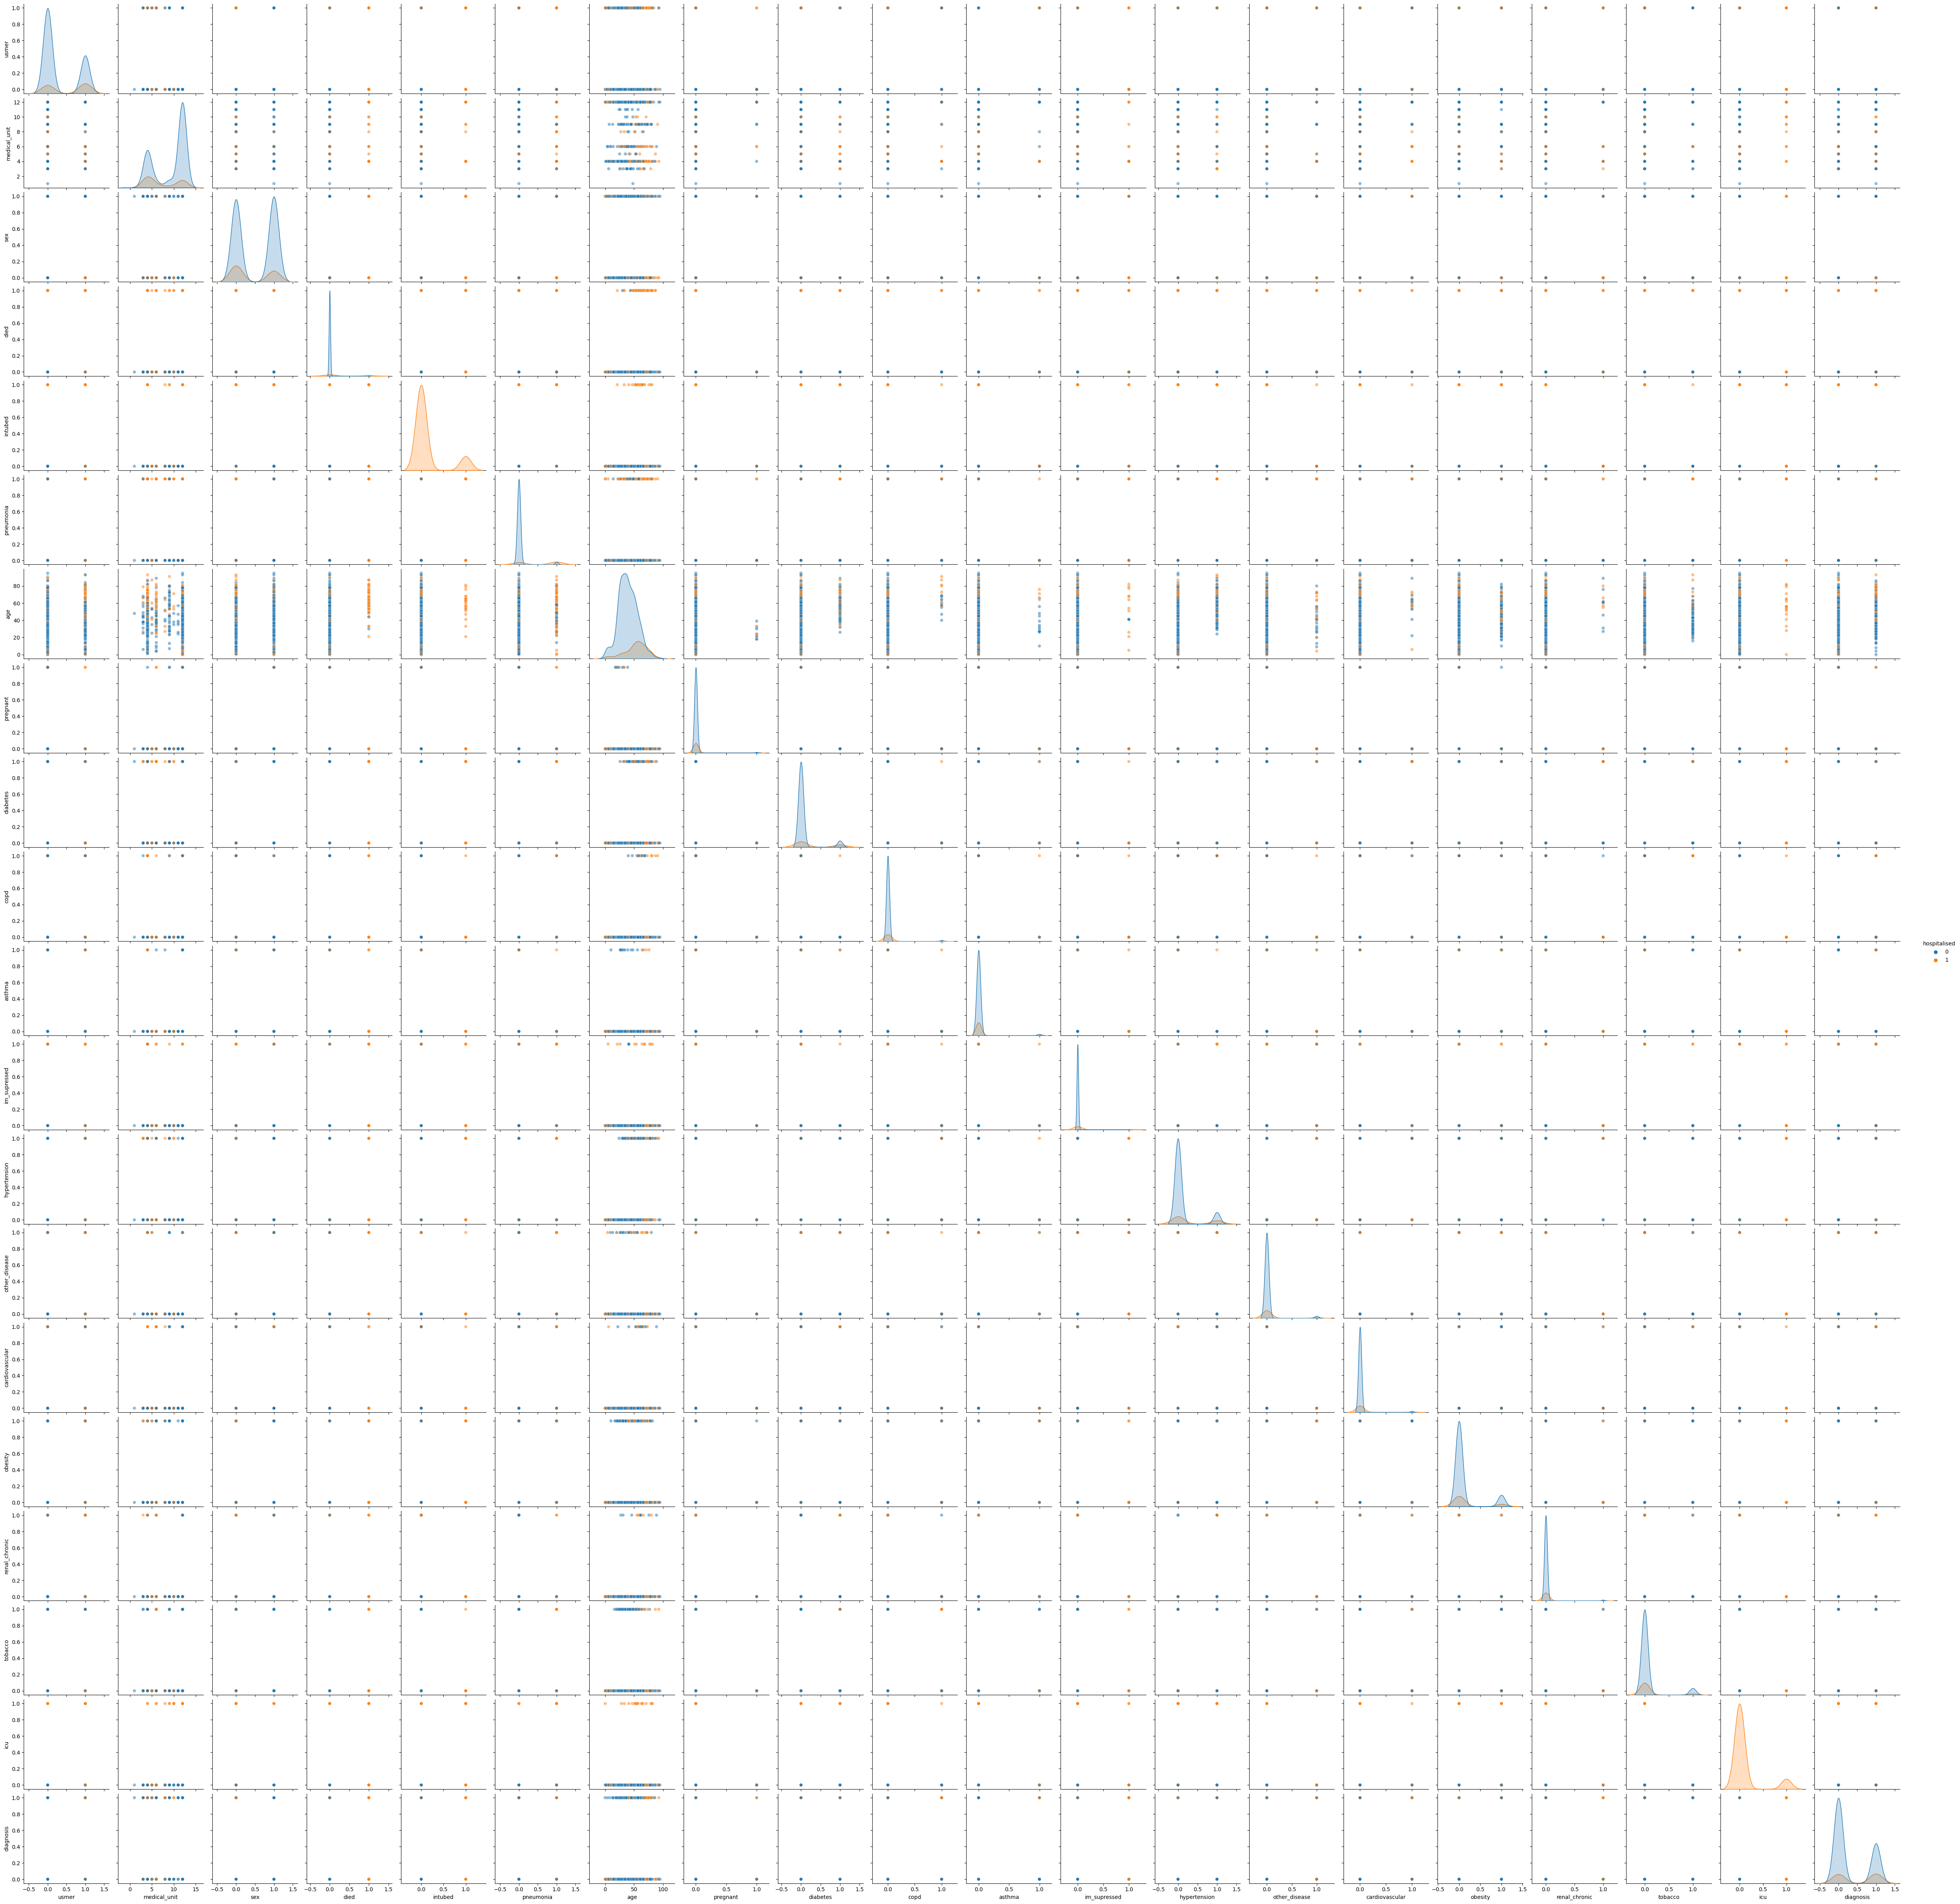

In [49]:
# Perform a pairplot to see if there are any obvious insights - unlikely given the binary nature of the features

sns.pairplot(df.sample(1000), hue = target[0], plot_kws = {'alpha': 0.5});

There are some features where it appears to have clear clumpings of teh target. Look into this in more detail below with individual plots

In [50]:
# Set the plotting style for seaborn and matplotlib

style = {"axes.edgecolor": "white", "grid.color": "lightgrey"}
sns.set_style('white', rc = style)

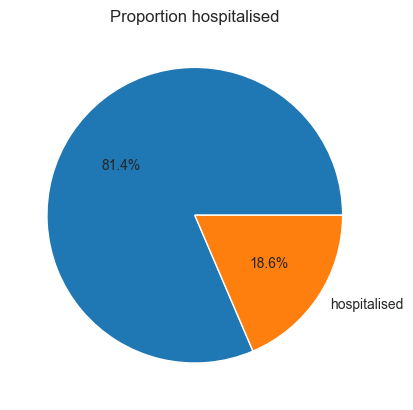

In [100]:
# Visualise the proportions of people hospitalised

plt.pie(df.value_counts(target[0]).sort_index(), labels = ['', target[0]], autopct = '%0.1f%%')
plt.title(f'Proportion {target[0]}');

Just under 20% of people were hospitalised

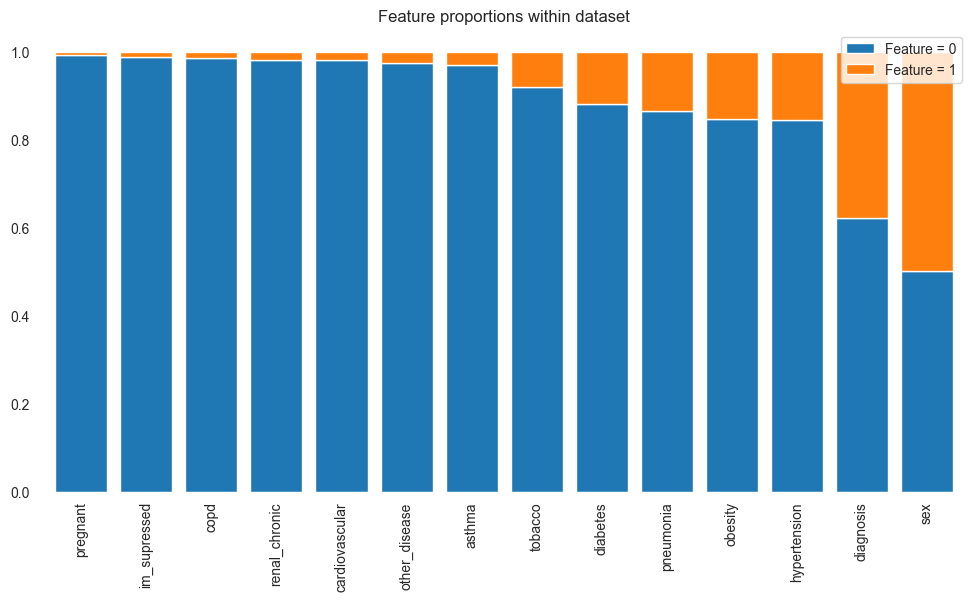

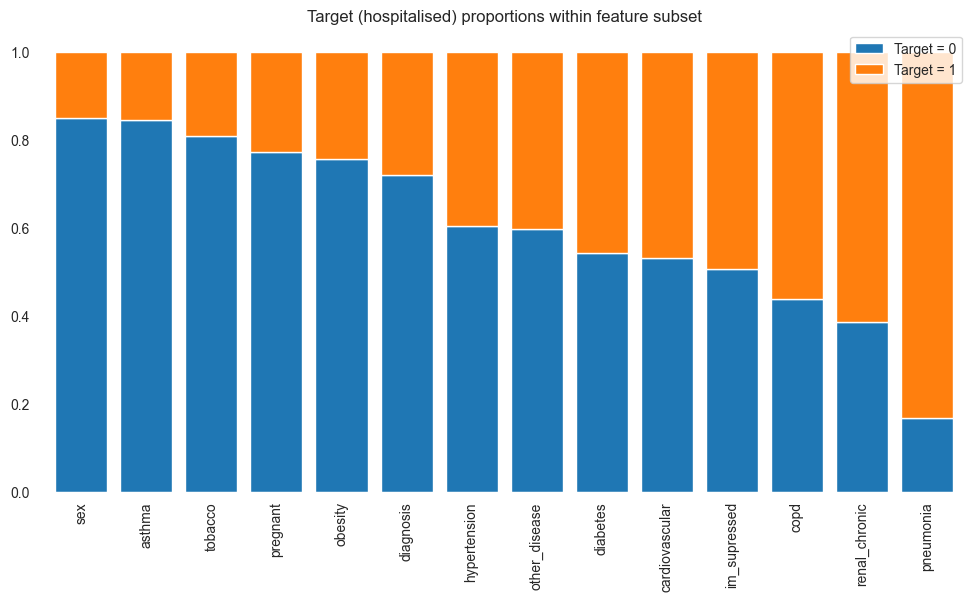

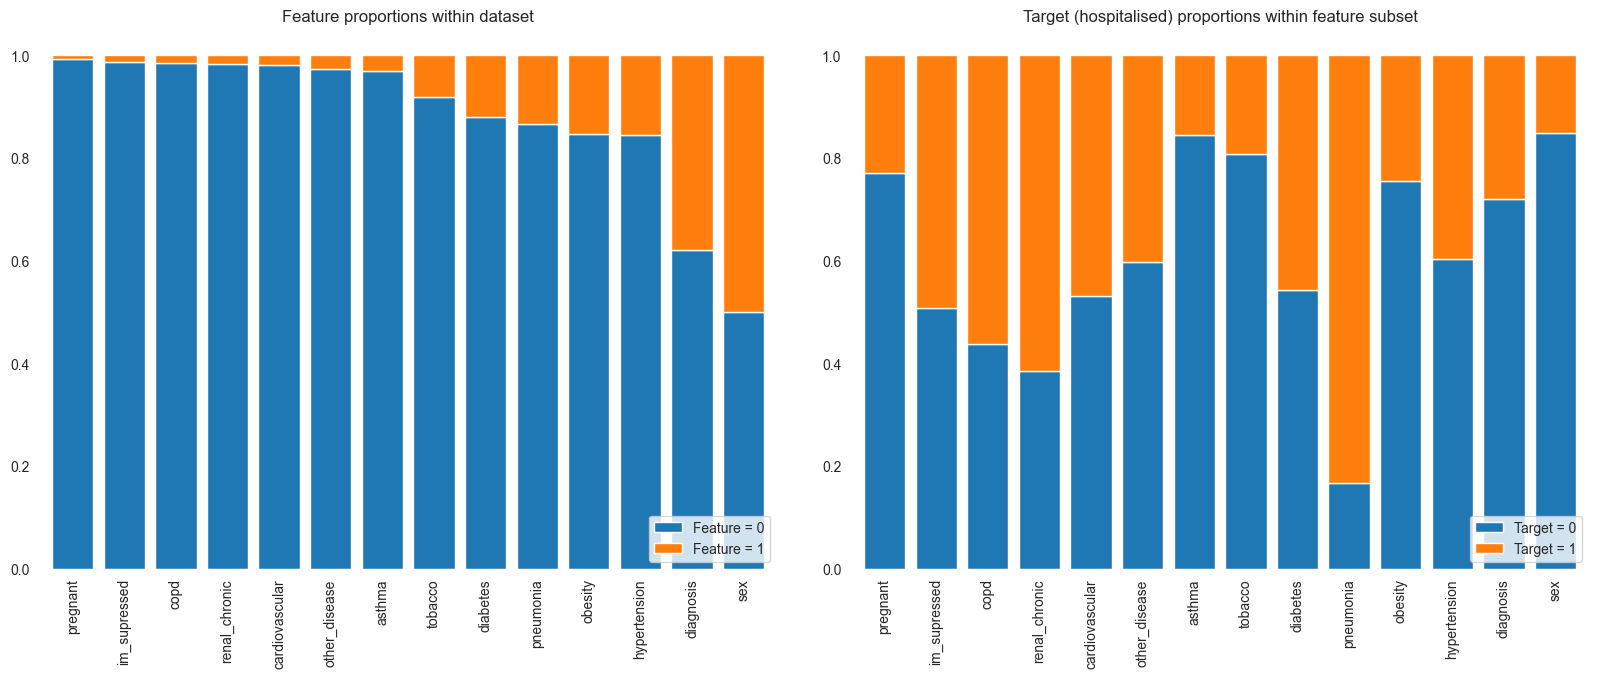

In [51]:
# Plot stacked percentage bar plots of the various binary conditions showing the target percentage

# Calculate the values for each of the features
counts = []
for feature in binary_features:
    feature_0 = df[feature].value_counts().loc[0]
    feature_1 = df[feature].value_counts().loc[1]
    feature_sum = feature_0 + feature_1
    try:
        target_0 = df[df[feature] == 1].value_counts(target[0]).loc[0]
    except:
        KeyError
        target_0 = 0
    target_1 = df[df[feature] == 1].value_counts(target[0]).loc[1]
    target_sum = target_0 + target_1
    counts.append([feature, feature_0/feature_sum, feature_1/feature_sum, target_0/target_sum, target_1/target_sum])

counts_df = pd.DataFrame(counts, columns = ['feature', 'Feature = 0', 'Feature = 1', 'Target = 0', 'Target = 1']).set_index('feature').sort_values(by = 'Feature = 0', ascending = False)

# Plot the proportions of the features
counts_df[['Feature = 0', 'Feature = 1']].plot.bar(stacked = True, figsize = (12,6), edgecolor = 'white', width = 0.8)
plt.title('Feature proportions within dataset')
plt.xlabel('');

# Plot the proportions of the target
counts_df[['Target = 0', 'Target = 1']].sort_values(by = 'Target = 0', ascending = False).plot.bar(stacked = True, figsize = (12,6), edgecolor = 'white', width = 0.8)
plt.title(f'Target ({target[0]}) proportions within feature subset')
plt.xlabel('');

# Plot the figures together preserving the feature order
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,7))
plt.subplots_adjust(wspace = 0.1)
counts_df[['Feature = 0', 'Feature = 1']].plot.bar(stacked = True, edgecolor = 'white', width = 0.8, ax = ax1)
counts_df[['Target = 0', 'Target = 1']].plot.bar(stacked = True, edgecolor = 'white', width = 0.8, ax = ax2)
ax1.set_title('Feature proportions within dataset')
ax1.set_xlabel('')
ax2.set_title(f'Target ({target[0]}) proportions within feature subset')
ax2.set_xlabel('')
ax1.legend(loc = 'lower right')
ax2.legend(loc = 'lower right');

There are multiple features that have very small representation in the general dataset, however, they have significant representation in the target. This could make it hard for the model to make accurate predictions.  

It might be wortwhile to boost the number of target cases in the training dataset.

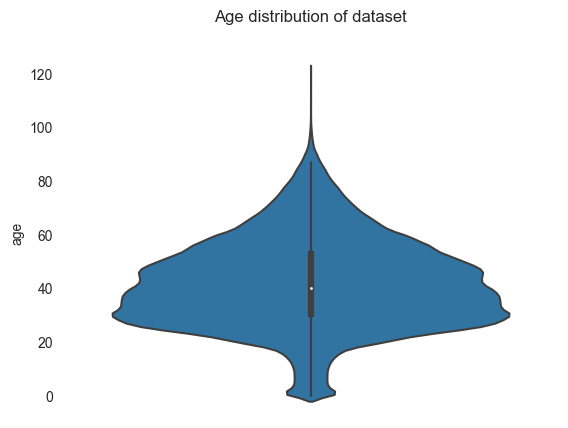

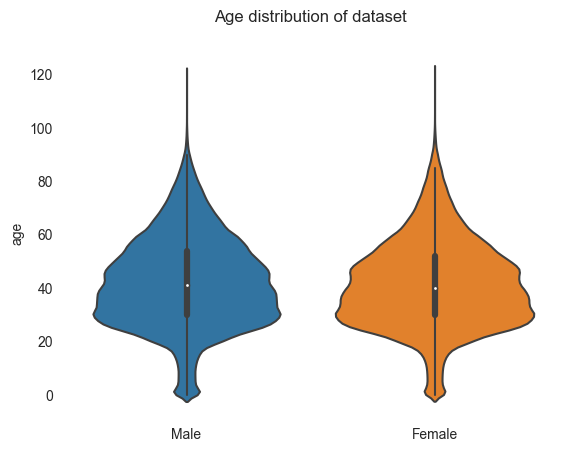

In [52]:
# Visualise the age distribution of the dataset

# The dataset as a whole
sns.violinplot(data = df, y = 'age'),
# plt.xticks(ticks = [0,1], labels = ['Male', 'Female'])
plt.xlabel('')
plt.title(f'Age distribution of dataset', y = 1.05)
plt.show()

# Split be gender
sns.violinplot(data = df, x = 'sex', y = 'age'),
plt.xticks(ticks = [0, 1], labels = ['Male', 'Female'])
plt.xlabel('')
plt.title(f'Age distribution of dataset', y = 1.05)
plt.show()

The age distribution appears to be fairly standard with minimal difference between genders. There are some people who are extremely old (>100).

In [53]:
# Check how many people are over the age of 100

print(f'Number of people over 100 = {df[df["age"] > 100].age.count()}')
print(f'Number of people over 100 and {target[0]} = {df[(df["age"] > 100)][target[0]].sum()}')

Number of people over 100 = 123
Number of people over 100 and hospitalised = 27


Dropping the very old patients since this could be false data.

In [54]:
# Drop rows where the age is over 100 since these appear to be outliers

df = df[df['age'] <= 100]
df['age'].max()

100

In [55]:
# # Visualise the age distributions of people affected by covid with violin plots - histogram plots below are much better at showing the differences

# # Grouped by diagnosis
# sns.violinplot(data = df, y = 'age', bins = 20, x = 'diagnosis')
# plt.title('Diagnosis distribution', y = 1.05)
# plt.show();

# # Grouped by hospitalisation
# sns.violinplot(data = df, y = 'age', bins = 20, x = 'hospitalised')
# plt.title('Hospitalisation distribution', y = 1.05)
# plt.show();

# # Grouped by ICU
# sns.violinplot(data = df, y = 'age', bins = 20, x = 'icu')
# plt.title('ICU distribution', y = 1.05)
# plt.show();

# # Grouped by death
# sns.violinplot(data = df, y = 'age', bins = 20, x = 'died')
# plt.title('Death distribution', y = 1.05)
# plt.show();

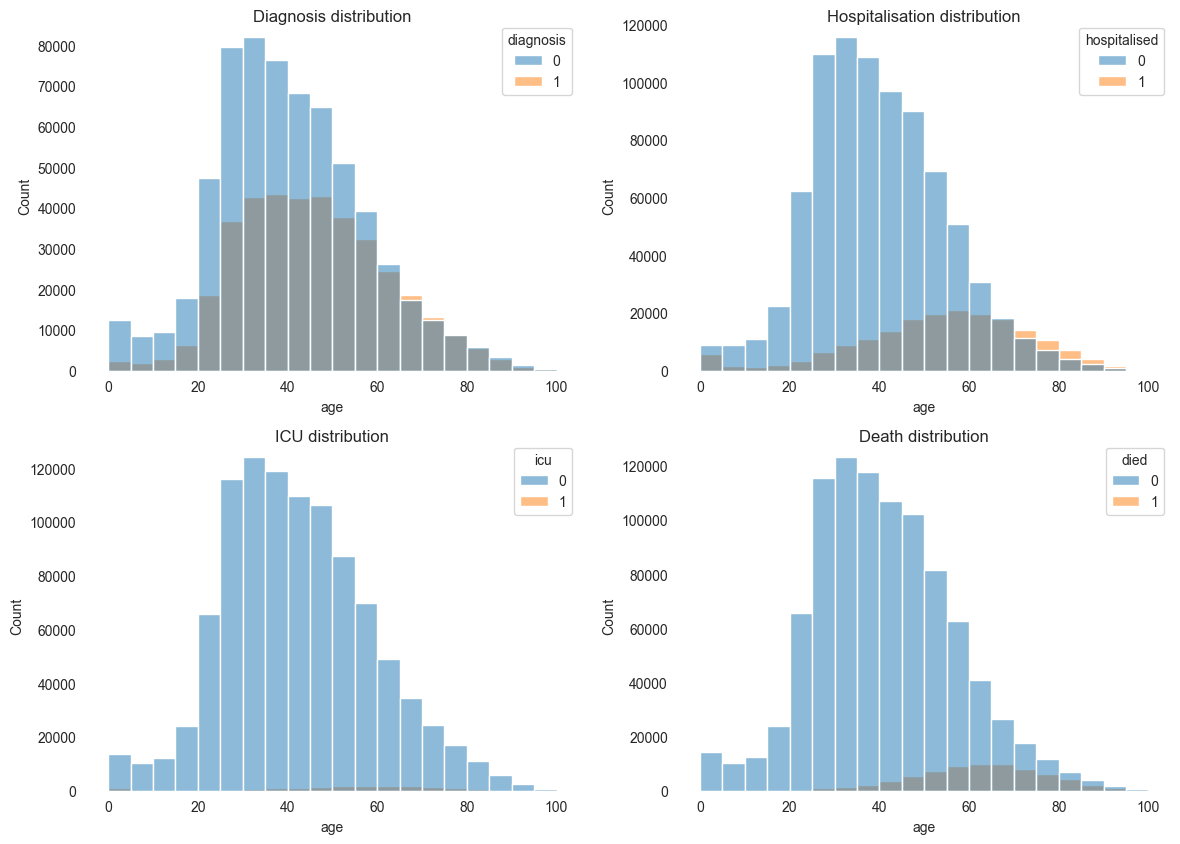

In [56]:
# Visualise the age distributions of people affected by covid with histograms

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
fig, ([[ax1, ax2],[ ax3, ax4]]) = plt.subplots(2, 2, figsize = (14, 10))
title_height = 0.975
# Grouped by diagnosis
sns.histplot(data = df, x = 'age', bins = 20, hue = 'diagnosis', ax=ax1)
ax1.set_title('Diagnosis distribution', y = title_height)

# Grouped by hospitalisation
sns.histplot(data = df, x = 'age', bins = 20, hue = 'hospitalised', ax = ax2)
ax2.set_title('Hospitalisation distribution', y = title_height)

# Grouped by ICU
sns.histplot(data = df, x = 'age', bins = 20, hue = 'icu', ax = ax3)
ax3.set_title('ICU distribution', y = title_height)

# Grouped by death
sns.histplot(data = df, x = 'age', bins = 20, hue = 'died', ax = ax4)
ax4.set_title('Death distribution', y = title_height)
plt.show();

The outcome of a diagnosis appears to be independent of age, however, hospitalisation, admission to ICU, and death appear to be skewed towards older ages.

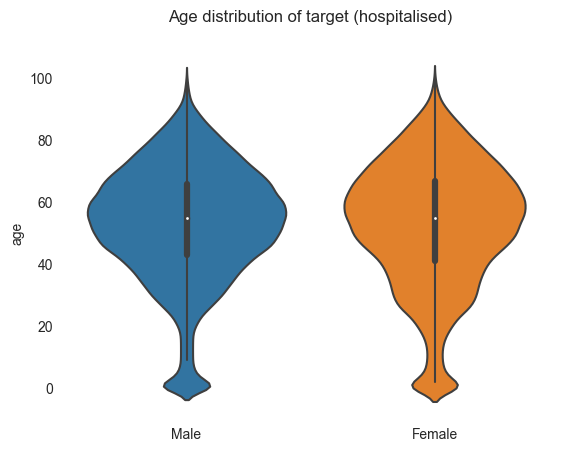

In [57]:
# Visualise the age distributions of the target

sns.violinplot(data = df[df[target[0]] == 1], x = 'sex', y = 'age')
plt.xticks(ticks = [0, 1], labels = ['Male', 'Female'])
plt.xlabel('')
plt.title(f'Age distribution of target ({target[0]})', y = 1.05);

The age distribution of the target is very even between genders.

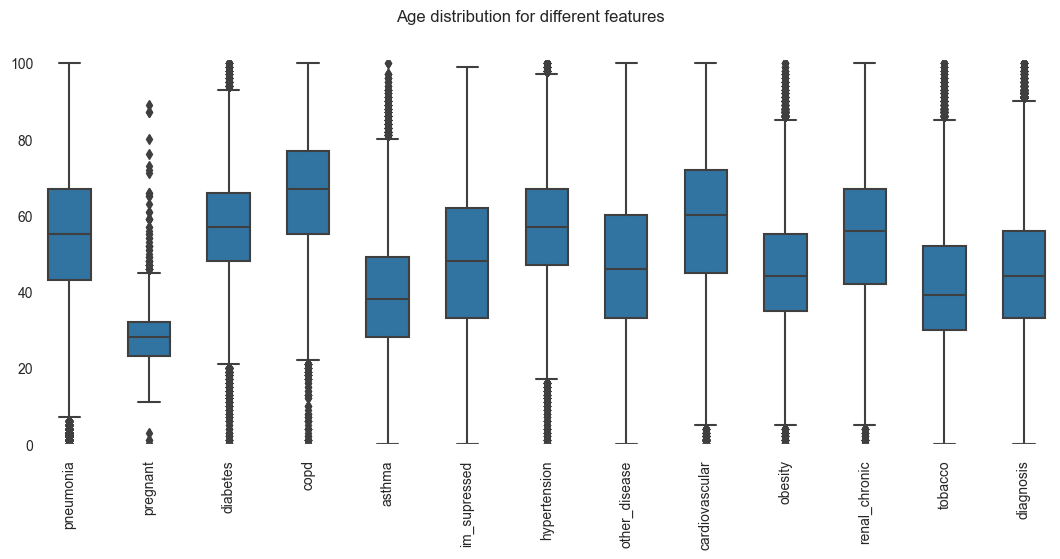

In [58]:
# Plot the age distributions for the binary features 

# Set up the subplots
features_not_sex = [col for col in binary_features if col != 'sex']
fig, axes = plt.subplots(nrows = 1, ncols = len(features_not_sex), figsize=(len(features_not_sex), 5))
# Create violin plots for each column and drop nan values
for i, f in enumerate(features_not_sex):
    # sns.violinplot(y = df[df[f] == 1]['age'].dropna(), ax=axes[i])
    sns.boxplot(data = df, y = df[df[f] == 1]['age'].dropna(), ax = axes[i])
    axes[i].set_xlabel(f, rotation = 90)
    axes[i].set_xticks(ticks = [0], labels = [''])
    axes[i].set_ylabel('')
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_ylim([0, 101])
plt.subplots_adjust(wspace = 0.5)
axes[0].get_yaxis().set_visible(True)
plt.suptitle('Age distribution for different features')
plt.show()

There are some people who are very young/old to be pregnant, as well as very young to be tobacco users.

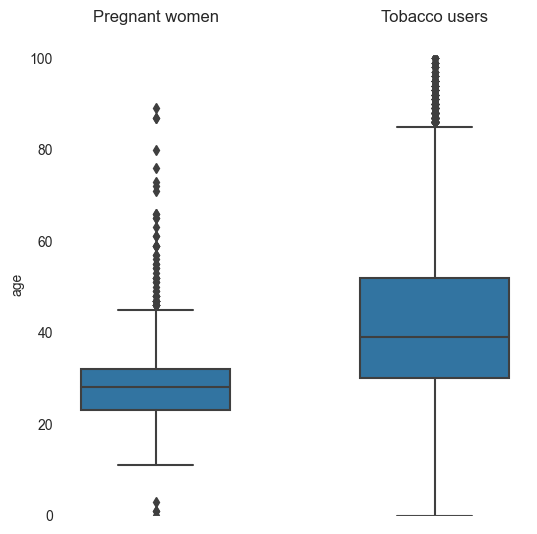

In [59]:
# Look at the age distribution of women who were pregnant and tobacco users

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 6))

sns.boxplot(data = df[df['pregnant'] == 1], y = 'age', ax = ax1)
sns.boxplot(data = df[df['tobacco'] == 1], y = 'age', ax = ax2)
ax1.set_title('Pregnant women', y= 1.05)
ax1.set_ylim([0, 101])
ax2.set_ylabel('')
ax2.set_title('Tobacco users', y= 1.05)
ax2.get_yaxis().set_visible(False)
ax2.set_ylim([0, 101])
plt.subplots_adjust(wspace = 0.5)
plt.show();

There are datapoints with women being pregnant at very young and very old ages as well as very young tobacco users. 
Drop these rows since they are (hopefully) mislabelled

There are 34 pregnancy rows to be dropped
There are 338 tobacco rows to be dropped


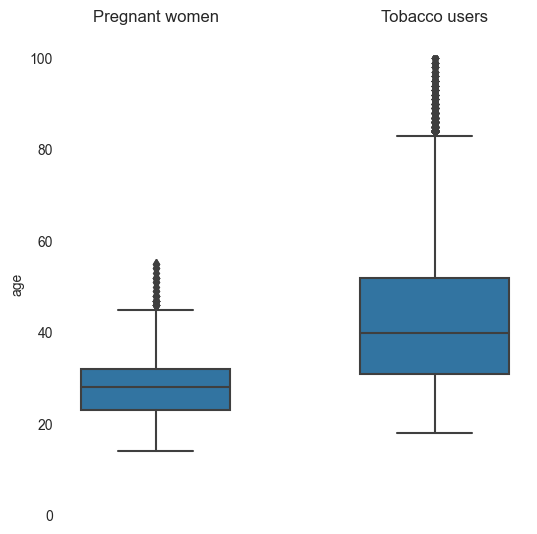

In [60]:
# Remove rows of data with very low/high pregnancy age, and very low tobacco use age

# Drop the rows where women are pregnant and younger than 14 or older than 55
print(f'There are {df[((df["age"] > 55) & (df["pregnant"] == 1)) | ((df["age"] < 14) & (df["pregnant"] == 1))]["age"].count()} pregnancy rows to be dropped')

df = df.drop(df[((df['age'] > 55) & (df['pregnant'] == 1)) | ((df['age'] < 14) & (df['pregnant'] == 1))].index)

# Drop the rows where tobacco users are younger than 18
print(f'There are {df[(df["tobacco"] == 1) & (df["age"] < 18)]["age"].count()} tobacco rows to be dropped')

df = df.drop(df[(df["tobacco"] == 1) & (df["age"] < 18)]["age"].index)


# Replot the boxplots

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 6))

sns.boxplot(data = df[df['pregnant'] == 1], y = 'age', ax = ax1)
sns.boxplot(data = df[df['tobacco'] == 1], y = 'age', ax = ax2)
ax1.set_title('Pregnant women', y= 1.05)
ax1.set_ylim([0, 101])
ax2.set_ylabel('')
ax2.set_title('Tobacco users', y= 1.05)
ax2.get_yaxis().set_visible(False)
ax2.set_ylim([0, 101])
plt.subplots_adjust(wspace = 0.5)
plt.show()

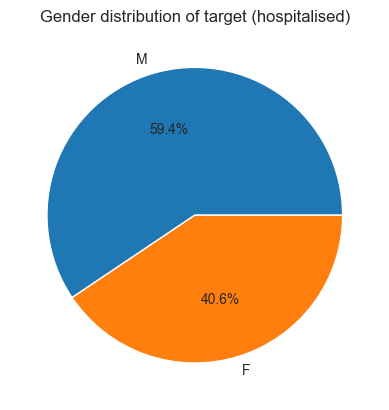

In [61]:
# Visualise the gender proportions of the target

plt.pie(df[df[target[0]] == 1].value_counts('sex').sort_index(), labels = ['M', 'F'], autopct = '%0.1f%%')
plt.title(f'Gender distribution of target ({target[0]})');

Men are around 50% more likely to be hospitalised than women

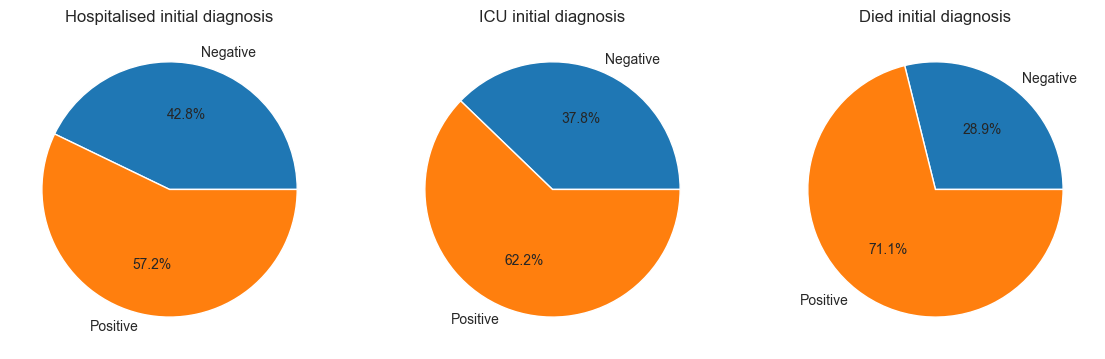

In [62]:
# Visualise the diagnosis proportions for people who were hospitalised, admitted to ICU, or died

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 7))
# Hospitalised
ax1.pie(df[df['hospitalised'] == 1].value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax1.set_title('Hospitalised initial diagnosis')
# ICU
ax2.pie(df[df['icu'] == 1].value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax2.set_title('ICU initial diagnosis')
# Died
ax3.pie(df[df['died'] == 1].value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax3.set_title('Died initial diagnosis')
plt.show()

There are a significant number of people are hospitalised that were intially diagnosed as negative or inconclusive. This trend drops off with more severe cases.  

This indicates that there would be a real benefit in increasing the accuracy of COVID-19 tests.

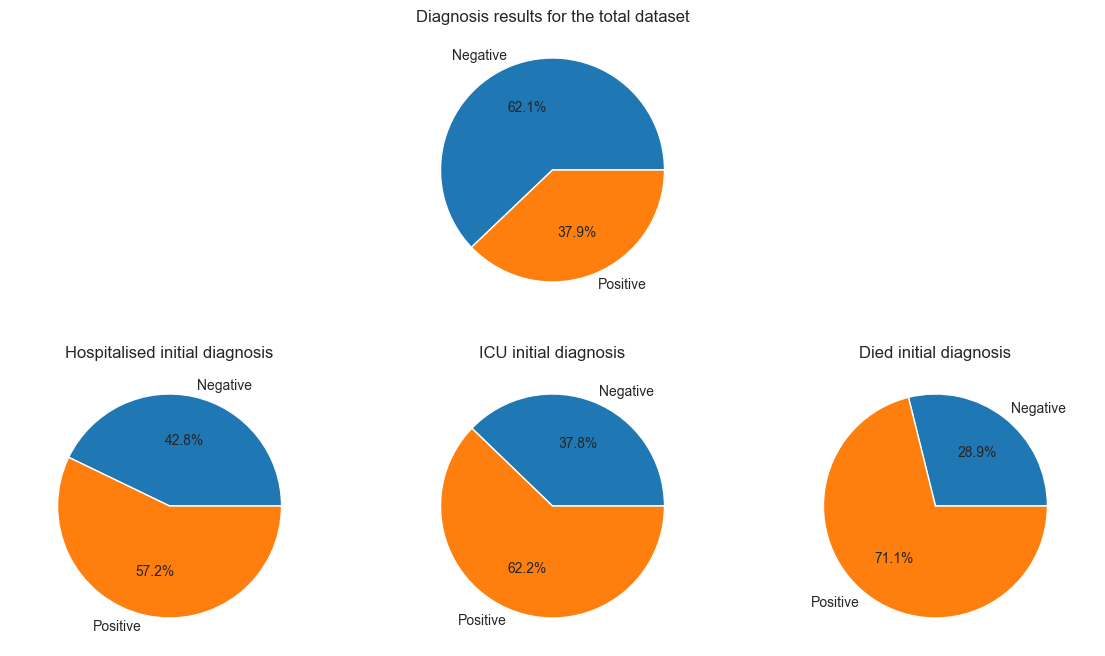

In [63]:
# Plot the same as above but with the total dataset diagnosis centred on the top row

# Visualise the diagnosis proportions for people who were hospitalised, admitted to ICU, or died

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (14, 8))
# Diagnosed
ax1.axis('off')
ax3.axis('off')
ax2.pie(df.value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax2.set_title('Diagnosis results for the total dataset')
# Hospitalised
ax4.pie(df[df['hospitalised'] == 1].value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax4.set_title('Hospitalised initial diagnosis')
# ICU
ax5.pie(df[df['icu'] == 1].value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax5.set_title('ICU initial diagnosis')
# Died
ax6.pie(df[df['died'] == 1].value_counts('diagnosis').sort_index(), labels = ['Negative', 'Positive'], autopct = '%0.1f%%')
ax6.set_title('Died initial diagnosis')
plt.show()

## Modelling

### Create some subsets of the data for training the models on

In [64]:
# Create the train and test datasets

# Change the df dtypes to int8 for reduced memory use
df = df.astype('int8')

# Create random samples of the dataframe to train and test the model on
sample_size = 10000
general_sample = df.sample(sample_size, random_state = seed)

# Create a new dataframe that has a biased number of positive target rows to better incorporate minority features that are over-represented in the target group
# Create a sample of the dataset that is only the target rows
target1_ratio = 0.5
target0_ratio = 1 - target1_ratio
target1_sample = df[df[target[0]] == 1].sample(int(target1_ratio * sample_size), random_state = seed)
target0_sample = df[df[target[0]] == 0].sample(int(target0_ratio * sample_size), random_state = seed)
frames = [target1_sample, target0_sample]

# Create a new dataframe that is a combination of the target df and the general df and shuffle the order
biased_sample = pd.concat(frames).sample(frac = 1, random_state = seed)


#Drawing from the general dataset
X = general_sample[all_features]
y = general_sample[target[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = seed)

# Drawing from the biased dataset
Xb = biased_sample[all_features]
yb = biased_sample[target[0]]
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, train_size = 0.7, random_state = seed)

print(f'Feature training size = {X_train.shape[0]} rows, {X_train.shape[1]} columns')
print(f'Features: {", ".join(all_features)}')
print(f'Target: {target[0]}')

Feature training size = 7000 rows, 15 columns
Features: sex, pneumonia, age, pregnant, diabetes, copd, asthma, im_supressed, hypertension, other_disease, cardiovascular, obesity, renal_chronic, tobacco, diagnosis
Target: hospitalised


### Create some functions for plotting data and reporting scores

In [87]:
# Create a function for plotting ROC curves

def plot_roc_auc(model, X, y, data_label, plot_title, multiple = False):

    roc_style = {"axes.edgecolor": "black"}
    sns.set_style('ticks', rc = roc_style)

    if multiple:
        for i, (Xi, yi) in enumerate(zip(X, y)):
            fpr, tpr, _ = roc_curve(yi, model.predict_proba(Xi)[:, 1])
            area = auc(fpr, tpr)

            plt.plot(fpr, tpr, label = f'{data_label[i]} AUC = {"%.3f" % area}')
            plt.plot([0,1], [0, 1], color = 'k', lw = 1.0, ls = '--')
            plt.legend(loc = 'lower right')
            plt.xlabel('False Positive Rate')
            plt.xlim([0,1])
            plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
    else:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        area = auc(fpr, tpr)

        plt.plot(fpr, tpr, label = f'{data_label} AUC = {"%.3f" % area}')
        plt.plot([0,1], [0, 1], color = 'k', lw = 1.0, ls = '--')
        plt.legend(loc = 'lower right')
        plt.xlabel('False Positive Rate')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.show()

    style = {"axes.edgecolor": "white", "grid.color": "lightgrey"}
    sns.set_style('white', rc = style)

# Create a function for plotting confusion matrices

def plot_confusion_matrix(model, X, y, plot_title):

    conf_mat = confusion_matrix(y, model.predict(X))
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    sns.heatmap(conf_mat, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(plot_title)
    plt.show()

# Create a function for printing out summary information

def print_model_summary(model, X, y, model_name):

    print('Classification report:\n')
    print(classification_report(y, model.predict(X)))
    
    try:
        param_dict = model.best_params_.items()
        print(f'{model_name} parameters:\n')
        for key, value in param_dict:
            print(f'{key} = {value}')
    except:
        AttributeError

## Decision tree classifier

#### General sample

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2428
           1       0.76      0.49      0.60       572

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000

Decision Tree classifier parameters:

ccp_alpha = 0.0
criterion = gini
max_depth = 8
max_features = sqrt
splitter = best


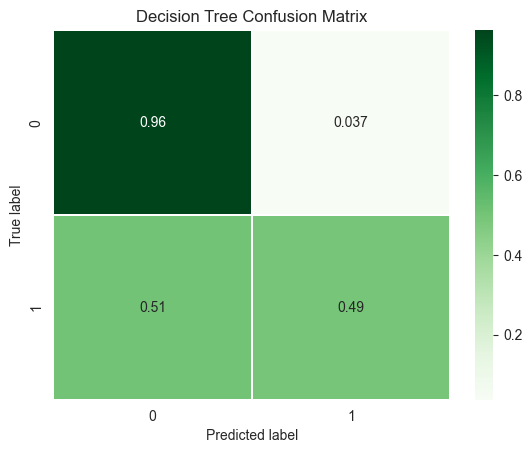

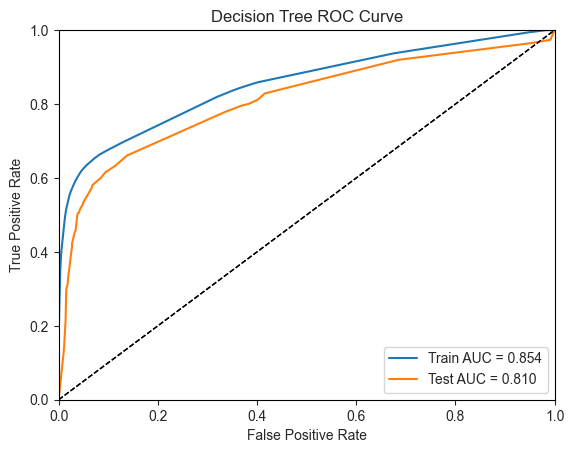

In [88]:
# Create a base Decision Tree Classifier and use gridsearch to find the best parameters

tree = DecisionTreeClassifier(
    random_state = seed
)

# Define the hyper parameters
tree_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [4, 6, 8, None],
    'max_features': ['sqrt', 'log2', 'auto'],
    'ccp_alpha': np.linspace(0,1,11)
}

# Grid search to find the best parameters
tree_gscv = GridSearchCV(tree, tree_params, cv = folds, n_jobs = 4,
                         scoring = make_scorer(f1_score)).fit(X_train, y_train)

print_model_summary(tree_gscv, X_test, y_test, 'Decision Tree classifier')
plot_confusion_matrix(tree_gscv, X_test, y_test, 'Decision Tree Confusion Matrix')
plot_roc_auc(tree_gscv, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Decision Tree ROC Curve', multiple = True)
# plot_tree(tree_gscv.best_estimator_);

The results of a base decision tree classifier are not encouraging. The model has no trouble predicting nnegative cases, but is no better than random guessign for positive cases.

## Random Forest classifier

#### General sample

In [67]:
# # Create a Random Forest Classifier and use gridsearch to find the best parameters

# forest = RandomForestClassifier(
#     n_jobs = 4,
#     random_state = seed
# )

# # Define the hyper parameters
# forest_params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [2, 4, 6],
#     'max_features': ['sqrt', 'log2', 'auto'],
#     'oob_score': [True, False],

# }

# # Grid search to find the best parameters
# forest_gscv = GridSearchCV(forest, forest_params, cv = folds, n_jobs = 4,
#                            scoring = make_scorer(f1_score)).fit(X_train, y_train)


# print_model_summary(forest_gscv, X_test, y_test, 'Random Forest classifier')
# plot_confusion_matrix(forest_gscv, X_test, y_test, 'Random Forest Confusion Matrix')
# plot_roc_auc(forest_gscv, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Random Forest ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2428
           1       0.82      0.60      0.69       572

    accuracy                           0.90      3000
   macro avg       0.86      0.78      0.81      3000
weighted avg       0.89      0.90      0.89      3000



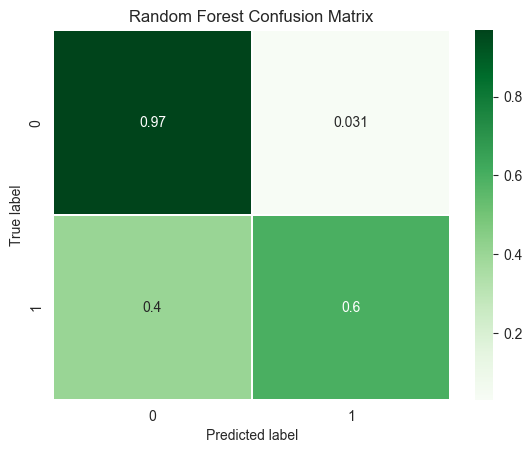

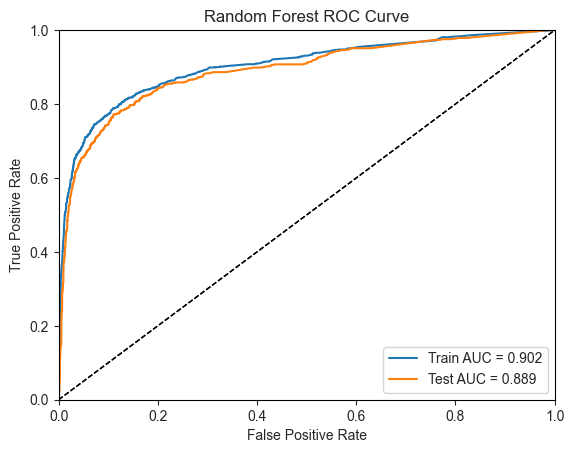

In [89]:
# Create a Random Forest Classifier based on the results of the gridsearch above

forest = RandomForestClassifier(
    n_jobs = 4,
    random_state = seed,
    criterion = 'gini',
    max_depth = 6,
    max_features = 'sqrt',
    n_estimators = 200,
    oob_score = True
)

# Grid search to find the best parameters
forest.fit(X_train, y_train)


print_model_summary(forest, X_test, y_test, 'Random Forest classifier')
plot_confusion_matrix(forest, X_test, y_test, 'Random Forest Confusion Matrix')
plot_roc_auc(forest, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Random Forest ROC Curve', multiple = True)

There is an improvement in model performance moving to a random forest classifier.

#### Biased sample

In [69]:
# # Grid search to find the best parameters
# forestB_gscv = GridSearchCV(forest, forest_params, cv = folds, n_jobs = 4,
#                            scoring = make_scorer(f1_score)).fit(Xb_train, yb_train)


# print_model_summary(forestB_gscv, Xb_test, yb_test, 'Biased sample Random Forest classifier')
# plot_confusion_matrix(forestB_gscv, Xb_test, yb_test, 'Biased sample Random Forest Confusion Matrix')
# plot_roc_auc(forestB_gscv, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample Random Forest ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1533
           1       0.87      0.73      0.80      1467

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



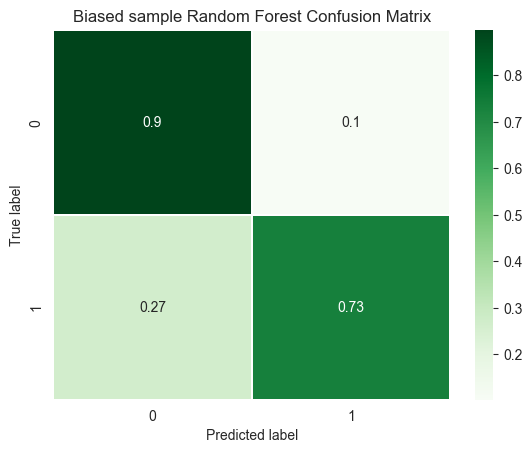

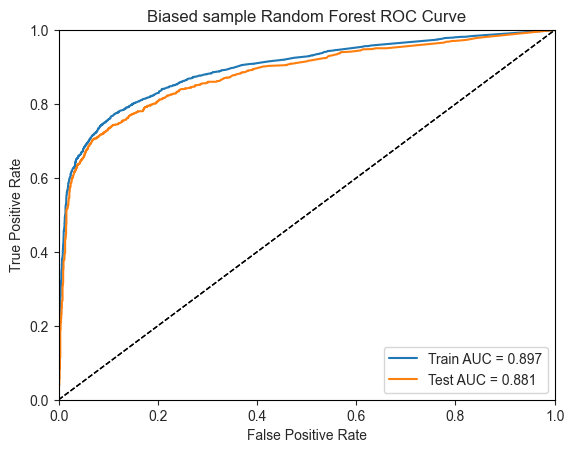

In [90]:
# Create a Random Forest Classifier based on the results of the gridsearch above

forestB = RandomForestClassifier(
    n_jobs = 4,
    random_state = seed,
    criterion = 'entropy',
    max_depth = 6,
    max_features = 'sqrt',
    n_estimators = 100,
    oob_score = True
)

# Grid search to find the best parameters
forestB.fit(Xb_train, yb_train)

print_model_summary(forestB, Xb_test, yb_test, 'Biased sample Random Forest classifier')
plot_confusion_matrix(forestB, Xb_test, yb_test, 'Biased sample Random Forest Confusion Matrix')
plot_roc_auc(forestB, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample Random Forest ROC Curve', multiple = True)

There is a clear improvement in model performance when oversampling the positive target cases.

## AdaBoost classifier

#### General sample

In [71]:
# # Create an Adaboost classifier

# # Create the base estimator
# tree_boost = DecisionTreeClassifier(
#     random_state = seed,
#     max_depth = 1
#     )

# # Create a boosting classifier
# boost = AdaBoostClassifier(
#     estimator = tree_boost,
#     random_state = seed)

# # Define the hyper parameters
# boost_params = {
#     'estimator__criterion': ['entropy', 'gini'],
#     'estimator__splitter': ['best', 'random'],
#     'estimator__max_features': ['sqrt', 'log2', 2],
#     'n_estimators': [50, 100, 200, 500],
#     'learning_rate': [0.2, 0.5, 1.0, 1.5, 2.0]
#     }

# # Grid search to find the best parameters
# boost_gscv = GridSearchCV(boost, param_grid = boost_params, n_jobs = 4, cv = folds,
#                           scoring = make_scorer(f1_score)).fit(X_train, y_train)


# print_model_summary(boost_gscv, X_test, y_test, 'AdaBoost classifier')
# plot_confusion_matrix(boost_gscv, X_test, y_test, 'AdaBoost Confusion Matrix')
# plot_roc_auc(boost_gscv, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'AdaBoost ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2428
           1       0.79      0.61      0.69       572

    accuracy                           0.90      3000
   macro avg       0.85      0.79      0.81      3000
weighted avg       0.89      0.90      0.89      3000



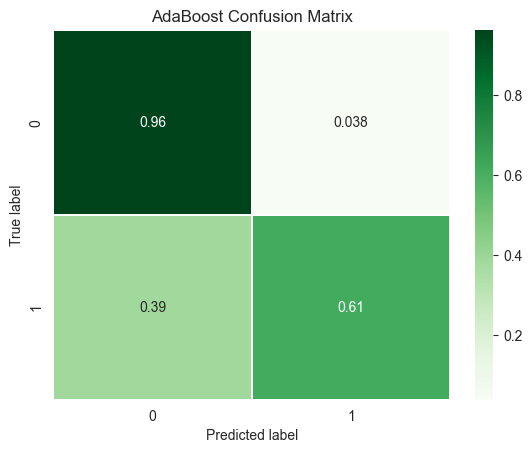

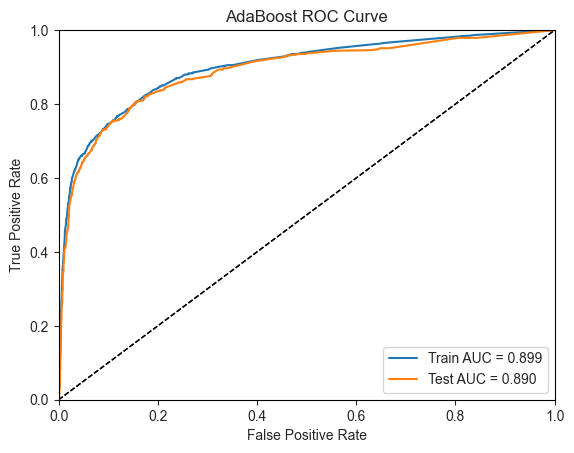

In [91]:
# Create an AdaBoost classifier based on the results of the gridsearch above

tree_boost = DecisionTreeClassifier(
    random_state = seed,
    max_depth = 1,
    criterion = 'entropy',
    max_features = 2,
    splitter = 'best'
    )

# Create a boosting classifier
boost = AdaBoostClassifier(
    estimator = tree_boost,
    random_state = seed,
    learning_rate = 1.0,
    n_estimators = 50
    )

boost.fit(X_train, y_train)

print_model_summary(boost, X_test, y_test, 'AdaBoost classifier')
plot_confusion_matrix(boost, X_test, y_test, 'AdaBoost Confusion Matrix')
plot_roc_auc(boost, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'AdaBoost ROC Curve', multiple = True)

There is a clear improvement in model performance when using an adaboost classifier.

#### Biased sample

In [73]:
# # Grid search to find the best parameters
# boostB_gscv = GridSearchCV(boost, param_grid = boost_params, n_jobs = 4, cv = folds,
#                           scoring = make_scorer(f1_score)).fit(Xb_train, yb_train)


# print_model_summary(boostB_gscv, Xb_test, yb_test, 'Biased sample AdaBoost classifier')
# plot_confusion_matrix(boostB_gscv, Xb_test, yb_test, 'Biased sample AdaBoost Confusion Matrix')
# plot_roc_auc(boostB_gscv, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample AdaBoost ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1533
           1       0.88      0.73      0.80      1467

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



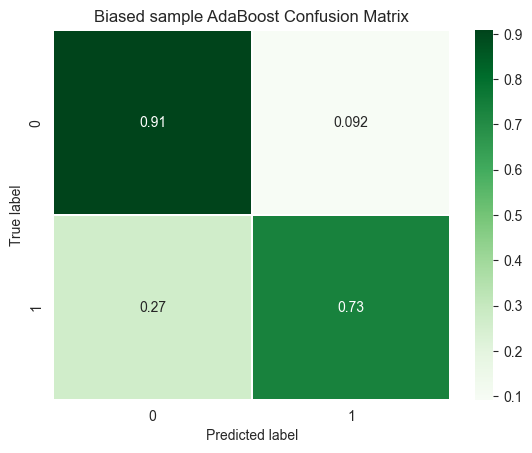

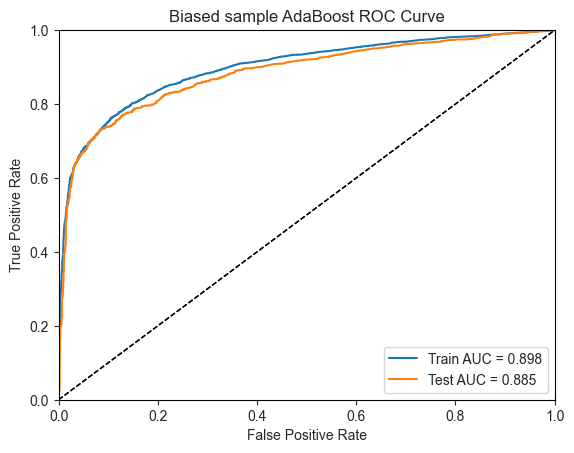

In [92]:
# Create an AdaBoost classifier based on the results of the gridsearch above

tree_boost = DecisionTreeClassifier(
    random_state = seed,
    max_depth = 1,
    criterion = 'entropy',
    max_features = 'sqrt',
    splitter = 'random'
    )

# Create a boosting classifier
boostB = AdaBoostClassifier(
    estimator = tree_boost,
    random_state = seed,
    learning_rate = 1.0,
    n_estimators = 500
    )

boostB.fit(Xb_train, yb_train)

print_model_summary(boostB, Xb_test, yb_test, 'Biased sample AdaBoost classifier')
plot_confusion_matrix(boostB, Xb_test, yb_test, 'Biased sample AdaBoost Confusion Matrix')
plot_roc_auc(boostB, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample AdaBoost ROC Curve', multiple = True)

The model has improved performance with the biased sample

## Gradient Boost classifier

#### General sample

In [75]:
# # Create a Gradient boosting classifier

# grad = GradientBoostingClassifier(
#     random_state = seed
#     )

# # Define the hyper parameters
# grad_params = {
#     'learning_rate': np.logspace(-2, 0, 5),
#     'n_estimators': [100, 200, 500],
#     'max_depth': [2, 4, 6],
#     'max_features': ['sqrt', 'log2', 1.0],
#     'ccp_alpha': np.linspace(0,1,11)
#     }

# # Grid search to find the best parameters
# grad_gscv = GridSearchCV(grad, param_grid = grad_params, n_jobs = 4, cv = folds,
#                          scoring = make_scorer(f1_score)).fit(X_train, y_train)


# print_model_summary(grad_gscv, X_test, y_test, 'Gradient Boost classifier')
# plot_confusion_matrix(grad_gscv, X_test, y_test, 'Gradient Boost Confusion Matrix')
# plot_roc_auc(grad_gscv, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Gradient Boost ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2428
           1       0.79      0.62      0.70       572

    accuracy                           0.90      3000
   macro avg       0.85      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



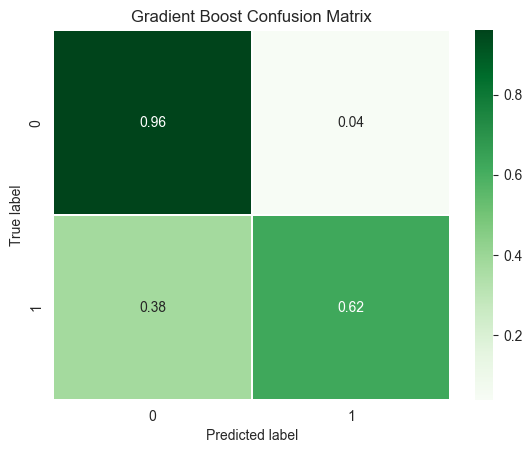

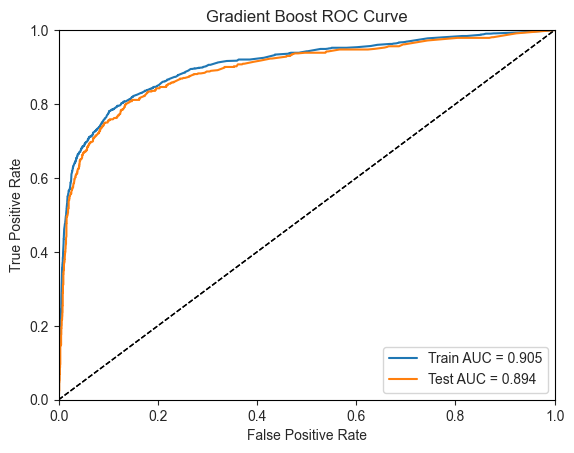

In [93]:
# Create a Gradient Boost classifier based on the results of the gridsearch above

grad = GradientBoostingClassifier(
    random_state = seed,
    ccp_alpha = 0.0,
    learning_rate = 0.1,
    max_depth = 2,
    max_features = 'sqrt',
    n_estimators = 200,
    )

grad.fit(X_train, y_train)

print_model_summary(grad, X_test, y_test, 'Gradient Boost classifier')
plot_confusion_matrix(grad, X_test, y_test, 'Gradient Boost Confusion Matrix')
plot_roc_auc(grad, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Gradient Boost ROC Curve', multiple = True)

#### Biased sample

In [77]:
# # Grid search to find the best parameters
# gradB_gscv = GridSearchCV(grad, param_grid = grad_params, n_jobs = 4, cv = folds,
#                          scoring = make_scorer(f1_score)).fit(Xb_train, yb_train)


# print_model_summary(gradB_gscv, Xb_test, yb_test, 'Biased sample Gradient Boost classifier')
# plot_confusion_matrix(gradB_gscv, Xb_test, yb_test, 'Biased sample Gradient Boost Confusion Matrix')
# plot_roc_auc(gradB_gscv, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample Gradient Boost ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1533
           1       0.87      0.75      0.81      1467

    accuracy                           0.83      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.83      0.82      3000



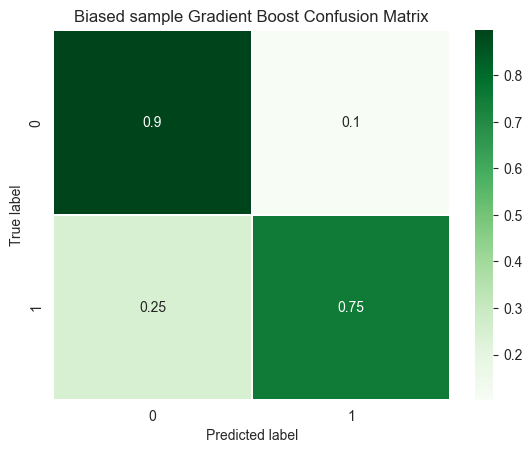

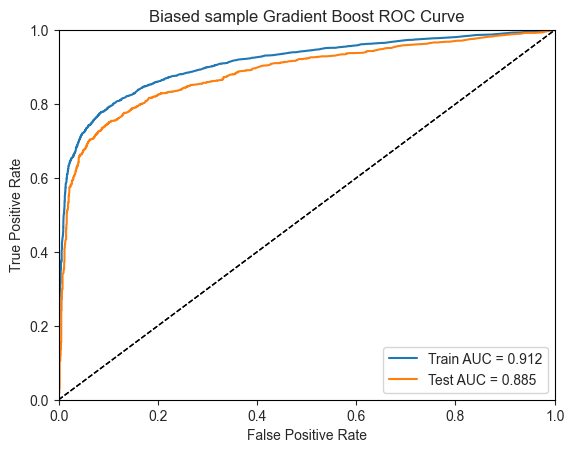

In [94]:
# Create a Gradient Boost classifier based on the results of the gridsearch above

gradB = GradientBoostingClassifier(
    random_state = seed,
    ccp_alpha = 0.0,
    learning_rate = 0.01,
    max_depth = 6,
    max_features = 'sqrt',
    n_estimators = 500,
    )

gradB.fit(Xb_train, yb_train)

print_model_summary(gradB, Xb_test, yb_test, 'Biased sample Gradient Boost classifier')
plot_confusion_matrix(gradB, Xb_test, yb_test, 'Biased sample Gradient Boost Confusion Matrix')
plot_roc_auc(gradB, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample Gradient Boost ROC Curve', multiple = True)

## Stacking classifier

#### General sample

In [79]:
# ### Commented out since this takes a very long time to run and the output is stored below ###

# # Create the models for the stacking classifier

# clf1 = KNeighborsClassifier(
#     n_jobs = 4
# )

# clf2 = RandomForestClassifier(
#     n_jobs = 4,
#     random_state = seed
# )

# clf3 = BernoulliNB()

# lr = LogisticRegression(
#     max_iter = 1000,
#     random_state = seed
# )

# # Create a list of hyper parameters for all of the models in the stacking classifier

# stack_params = {
#     'clf1__n_neighbors': list(range(1, 16, 2)),
#     'clf1__weights': ['uniform', 'distance'],
#     'clf1__p': [1, 2],
#     'clf2__n_estimators': [100, 200],
#     'clf2__max_depth': [4, 6, 8],
#     'clf2__max_features': ['sqrt', 'log2'],
#     'final_estimator__solver': ['liblinear', 'saga'],
#     'final_estimator__penalty': ['l1', 'l2'],
#     'final_estimator__C': np.logspace(-2, 1, 4)
# }

# # Create a list of sequential models for the stacking classifer

# estimators = [
#     ('clf1', clf1),
#     ('clf2', clf2),
#     ('clf3', clf3)
#     ]

# stack = StackingClassifier(estimators = estimators, final_estimator = lr)

# # Grid search to find the best parameters
# stack_gscv = GridSearchCV(stack, param_grid = stack_params, cv = folds, n_jobs = 4,
#                     scoring = make_scorer(f1_score), verbose = 1).fit(X_train, y_train)


# print_model_summary(stack_gscv, X_test, y_test, 'Stacking classifier')
# plot_confusion_matrix(stack_gscv, X_test, y_test, 'Stacking classifier Confusion Matrix')
# plot_roc_auc(stack_gscv, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Stacking classifier ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2428
           1       0.79      0.63      0.70       572

    accuracy                           0.90      3000
   macro avg       0.86      0.80      0.82      3000
weighted avg       0.89      0.90      0.89      3000



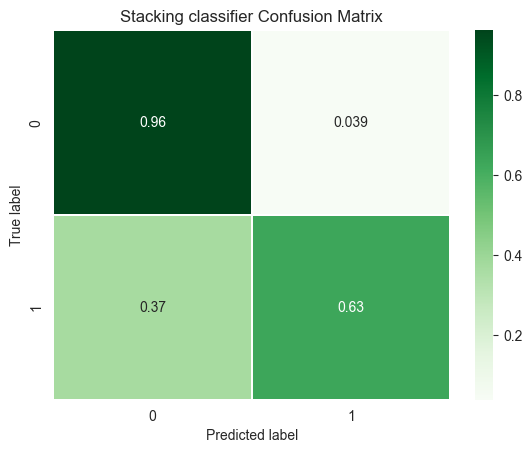

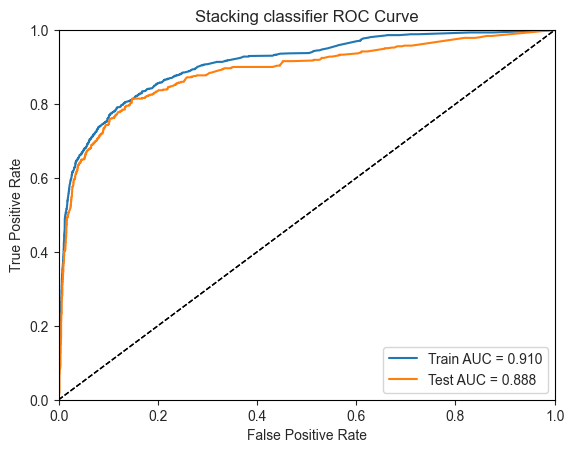

In [95]:
# Create the model for the stacking classifier based on the results of the gridsearch above

clf1 = KNeighborsClassifier(
    n_jobs = 4,
    n_neighbors = 15,
    p = 2,
    weights = 'uniform'
)

clf2 = RandomForestClassifier(
    n_jobs = 4,
    random_state = seed,
    max_depth = 4,
    max_features = 'sqrt',
    n_estimators = 100
)

clf3 = BernoulliNB()

lr = LogisticRegression(
    max_iter = 1000,
    random_state = seed,
    C = 10,
    penalty = 'l1',
    solver = 'liblinear'
)

estimators = [
    ('clf1', clf1),
    ('clf2', clf2),
    ('clf3', clf3)
    ]

stack = StackingClassifier(estimators = estimators, final_estimator = lr).fit(X_train, y_train)

print_model_summary(stack, X_test, y_test, 'Stacking classifier')
plot_confusion_matrix(stack, X_test, y_test, 'Stacking classifier Confusion Matrix')
plot_roc_auc(stack, [X_train, X_test], [y_train, y_test], ['Train', 'Test'], 'Stacking classifier ROC Curve', multiple = True)

#### Biased sample

In [81]:
# # Grid search to find the best parameters
# stackB_gscv = GridSearchCV(stack, param_grid = stack_params, cv = folds, n_jobs = 4,
#                     scoring = make_scorer(f1_score), verbose = 1).fit(Xb_train, yb_train)


# print_model_summary(stackB_gscv, Xb_test, yb_test, 'Biased sample Stacking classifier')
# plot_confusion_matrix(stackB_gscv, Xb_test, yb_test, 'Biased sample Stacking classifier Confusion Matrix')
# plot_roc_auc(stackB_gscv, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample Stacking classifier ROC Curve', multiple = True)

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1533
           1       0.85      0.76      0.80      1467

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



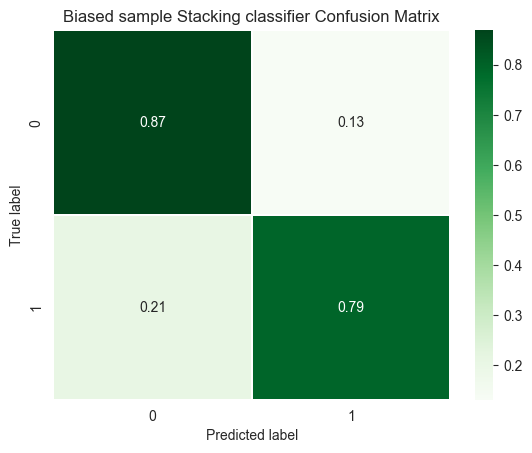

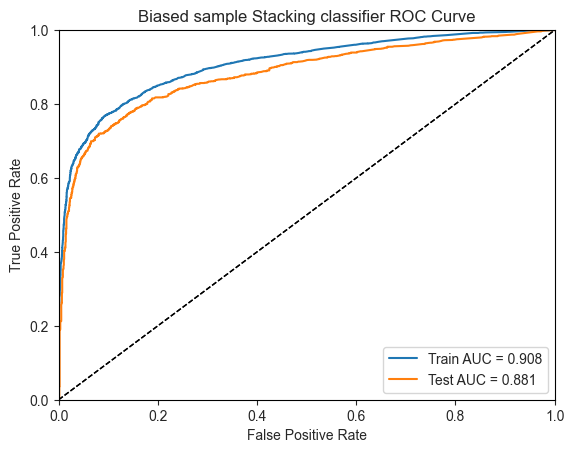

In [96]:
# Create the model for the stacking classifier based on the results of the gridsearch above

clfB1 = KNeighborsClassifier(
    n_jobs = 4,
    n_neighbors = 15,
    p = 1,
    weights = 'uniform'
)

clfB2 = RandomForestClassifier(
    n_jobs = 4,
    random_state = seed,
    max_depth = 8,
    max_features = 'sqrt',
    n_estimators = 200
)

clfB3 = BernoulliNB()

lrB = LogisticRegression(
    max_iter = 1000,
    random_state = seed,
    C = 0.1,
    penalty = 'l2',
    solver = 'saga'
)

estimatorsB = [
    ('clfB1', clfB1),
    ('clfB2', clfB2),
    ('clfB3', clfB3)
    ]

stackB = StackingClassifier(estimators = estimatorsB, final_estimator = lrB).fit(Xb_train, yb_train)

print_model_summary(stackB, Xb_test, yb_test, 'Biased sample Stacking classifier')
plot_confusion_matrix(stackB, X_test, y_test, 'Biased sample Stacking classifier Confusion Matrix')
plot_roc_auc(stackB, [Xb_train, Xb_test], [yb_train, yb_test], ['Train', 'Test'], 'Biased sample Stacking classifier ROC Curve', multiple = True)